In [69]:
!pip install prophet

In [70]:
#import dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
import matplotlib.pyplot as plt

In [71]:
# # upload US-Monthly-GDP-History-Data.csv
# from google.colab import files
# uploaded = files.upload()

In [72]:
# for reading in the US-Monthly-GDP-History-Data.csv in jupyter notebook 
# comment out when not in use
df= pd.read_csv('resources/US-Monthly-GDP-History-Data.csv')
df

,Unnamed: 0,Monthly Nominal GDP Index,Monthly Real GDP Index,Unnamed: 3,Unnamed: 4
0,1992 - Jan,6315.718,10177.808,NaN,NaN
1,1992 - Feb,6356.508,10222.919,NaN,NaN
2,1992 - Mar,6417.080,10307.964,NaN,NaN
3,1992 - Apr,6443.260,10314.310,NaN,NaN
4,1992 - May,6433.800,10293.473,NaN,NaN
...,...,...,...,...,...
398,NaN,NaN,NaN,NaN,NaN
399,NaN,NaN,NaN,NaN,NaN
400,NaN,NaN,NaN,NaN,NaN
401,NaN,NaN,NaN,NaN,NaN


In [73]:
# read in csv
# df= pd.read_csv('US-Monthly-GDP-History-Data.csv')
# df

In [74]:
# rename date column to 'Date'
# use .info() to learn more about the dataframe
df = df.rename(columns= {'Unnamed: 0': 'Date'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       391 non-null    object 
 1   Monthly Nominal GDP Index  391 non-null    float64
 2   Monthly Real GDP Index     391 non-null    float64
 3   Unnamed: 3                 0 non-null      float64
 4   Unnamed: 4                 0 non-null      float64
dtypes: float64(4), object(1)
memory usage: 15.9+ KB


In [75]:
# drop empty columns and rows
df = df[['Date', 'Monthly Nominal GDP Index', 'Monthly Real GDP Index']]
df = df.dropna()
display(df.head())
display(df.tail(10))

,Date,Monthly Nominal GDP Index,Monthly Real GDP Index
0,1992 - Jan,6315.718,10177.808
1,1992 - Feb,6356.508,10222.919
2,1992 - Mar,6417.080,10307.964
3,1992 - Apr,6443.260,10314.310
4,1992 - May,6433.800,10293.473


,Date,Monthly Nominal GDP Index,Monthly Real GDP Index
381,2023 - Oct,27757.209,22524.995
382,2023 - Nov,27936.313,22674.040
383,2023 - Dec,28177.472,22844.025
384,2024 - Jan,28072.857,22684.233
385,2024 - Feb,28360.395,22829.790
386,2024 - Mar,28374.270,22767.625
387,2024 - Apr,28553.963,22853.520
388,2024 - May,28687.910,22960.986
389,2024 - June,28717.658,22967.554
390,2024 - July,28909.887,23069.876


In [76]:
# create a dict and store the month abbrev. with their corresponding number
months= {'Jan': "01", 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05',
        'Jun': '06', 'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10',
         'Nov': '11', 'Dec': '12'}
# for each month abbrev. in 'Date' column, replace it with corresponding number

df['Date'] = df['Date'].replace(months, regex=True)

In [77]:
# convert to date to datetime
# set index to 'Date'
# take years only up until 2015

try:
    df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')
except Exception as e:
    print(e)

df = df.dropna(subset=['Date'])
gdp_df= df.set_index('Date')

gdp_df = gdp_df.loc['1992':'2015', ['Monthly Nominal GDP Index']]
gdp_df

C:\Users\linan\AppData\Local\Temp\ipykernel_29680\1029259486.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')


,Monthly Nominal GDP Index
Date,
1992-01-01,6315.718
1992-02-01,6356.508
1992-03-01,6417.080
1992-04-01,6443.260
1992-05-01,6433.800
...,...
2015-08-01,18379.862
2015-09-01,18456.886
2015-10-01,18469.416


<Axes: xlabel='Date'>

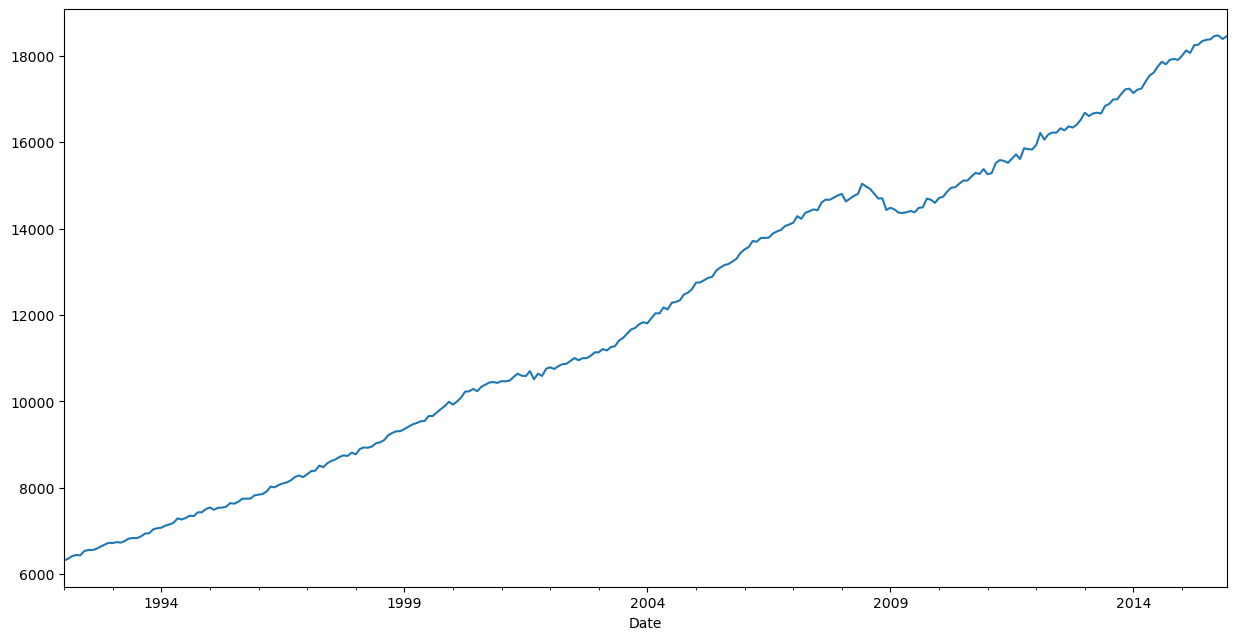

In [78]:
# visualize the dataframe
gdp_df['Monthly Nominal GDP Index']. plot(figsize=(15, 7.5))

<Axes: xlabel='Date'>

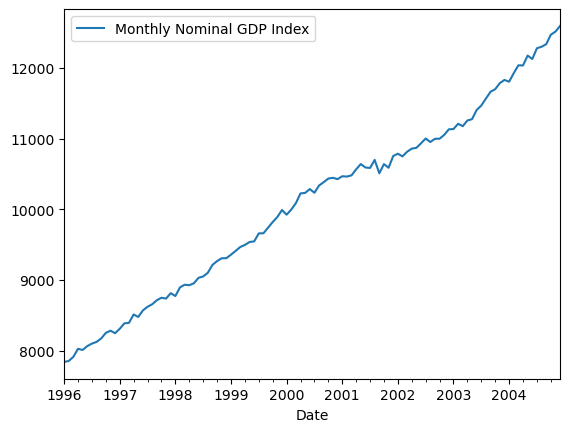

In [79]:
# visualize GDP from 1992 to 10 years after 9/11
gdp_df.loc['1996':'2004', ['Monthly Nominal GDP Index']].plot()


In [80]:
# reset index for gdp_df to prepare for prophet
# use 'Monthly Nominal GDP Index' to account for inflation and deflation
gdp_rs_index_df = gdp_df.reset_index()
gdp_rs_index_df = gdp_rs_index_df[['Date', 'Monthly Nominal GDP Index']]
gdp_rs_index_df

,Date,Monthly Nominal GDP Index
0,1992-01-01,6315.718
1,1992-02-01,6356.508
2,1992-03-01,6417.080
3,1992-04-01,6443.260
4,1992-05-01,6433.800
...,...,...
283,2015-08-01,18379.862
284,2015-09-01,18456.886
285,2015-10-01,18469.416
286,2015-11-01,18387.708


In [81]:
# slice gdp_rs_index_df up until 2001-09
# rename columns to 'ds', 'y'
nine_eleven_gdp_df = gdp_rs_index_df.loc[gdp_rs_index_df['Date'] < '2001-09']
nine_eleven_gdp_df = nine_eleven_gdp_df.rename(columns={'Date': 'ds', 'Monthly Nominal GDP Index': 'y'})
nine_eleven_gdp_df

,ds,y
0,1992-01-01,6315.718
1,1992-02-01,6356.508
2,1992-03-01,6417.080
3,1992-04-01,6443.260
4,1992-05-01,6433.800
...,...,...
111,2001-04-01,10565.350
112,2001-05-01,10639.985
113,2001-06-01,10591.666
114,2001-07-01,10585.078


In [82]:
# # Call the Prophet function, store as an object
model_9_11 = Prophet()
model_9_11

In [83]:
# fit the Prophet model
model_9_11.fit(nine_eleven_gdp_df)

20:18:31 - cmdstanpy - INFO - Chain [1] start processing
20:18:32 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 36 months (3 years)
future_9_11 = model_9_11.make_future_dataframe(periods=36, freq='M')

# View the last five rows of the predictions
future_9_11.tail()



c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds
147,2004-03-31
148,2004-04-30
149,2004-05-31
150,2004-06-30
151,2004-07-31


In [85]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_9_11 = model_9_11.predict(future_9_11)

# Display the first five rows of the forecast DataFrame
forecast_9_11.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,6351.963418,6292.098603,6390.763062,6351.963418,6351.963418,-12.076041,-12.076041,-12.076041,-12.076041,-12.076041,-12.076041,0.0,0.0,0.0,6339.887378
1,1992-02-01,6381.302174,6323.280693,6424.825122,6381.302174,6381.302174,-11.711173,-11.711173,-11.711173,-11.711173,-11.711173,-11.711173,0.0,0.0,0.0,6369.591001
2,1992-03-01,6408.748107,6341.806063,6443.956277,6408.748107,6408.748107,-17.731015,-17.731015,-17.731015,-17.731015,-17.731015,-17.731015,0.0,0.0,0.0,6391.017092
3,1992-04-01,6438.086863,6423.696211,6522.953563,6438.086863,6438.086863,34.208062,34.208062,34.208062,34.208062,34.208062,34.208062,0.0,0.0,0.0,6472.294925
4,1992-05-01,6466.479208,6412.968033,6517.375645,6466.479208,6466.479208,-0.568300,-0.568300,-0.568300,-0.568300,-0.568300,-0.568300,0.0,0.0,0.0,6465.910908


c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


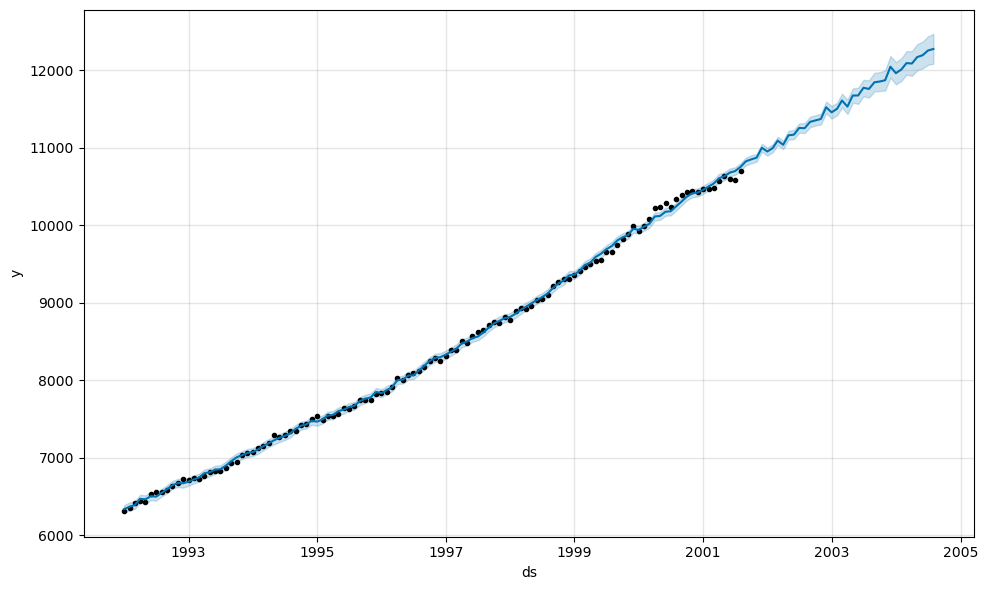

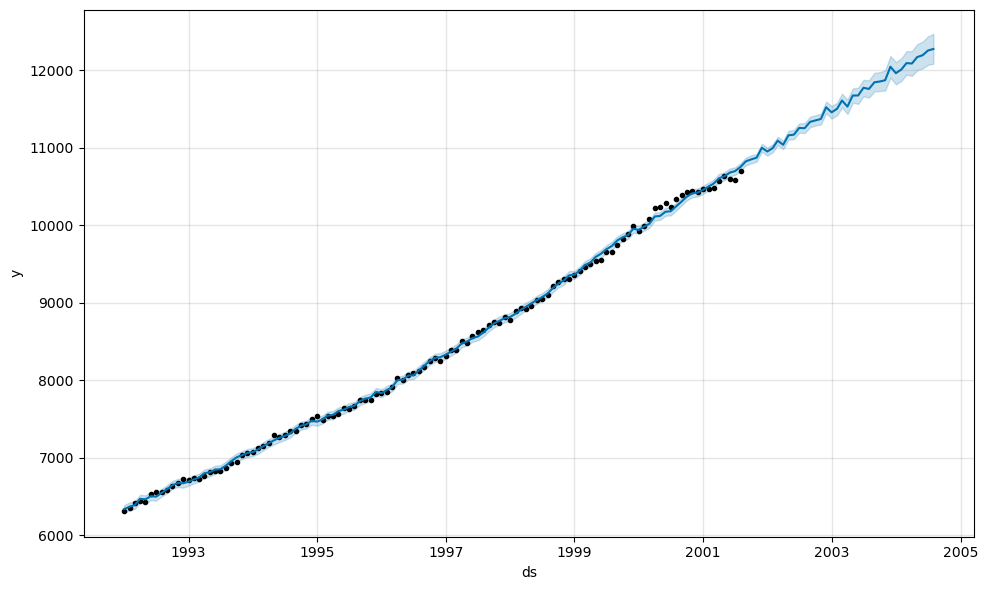

In [86]:
# Plot the Prophet predictions for the 9/11 trends data
model_9_11.plot(forecast_9_11)

c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

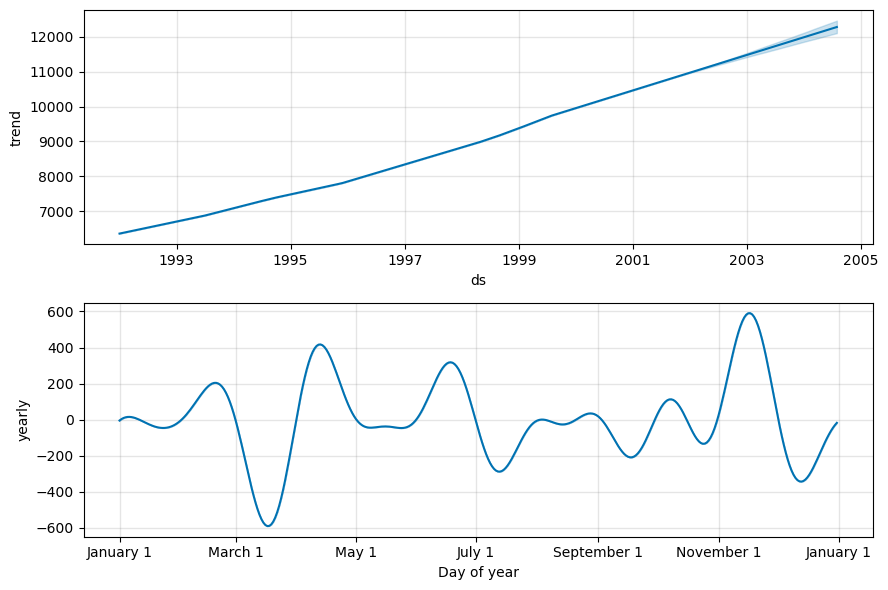

In [87]:
# Use the plot_components function to visualize the forecast results
figure = model_9_11.plot_components(forecast_9_11)

<Axes: xlabel='ds'>

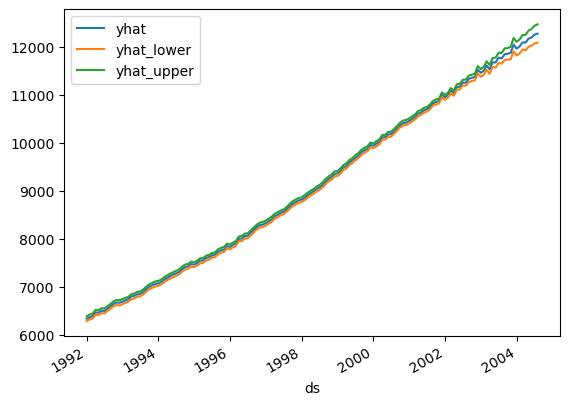

In [88]:
# set 'ds' as index
# From the `forecast_9_11` DataFrame, plot to visualize
# the yhat, yhat_lower, and yhat_upper columns
forecast_9_11 = forecast_9_11.set_index('ds')
forecast_9_11[['yhat', 'yhat_lower', 'yhat_upper']].plot()

<Axes: xlabel='Date'>

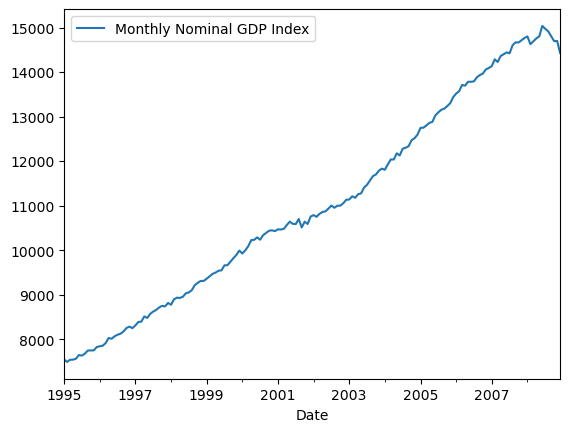

In [89]:
# create a df for hurricane Katrina
gdp_df.loc['1995':'2008', ['Monthly Nominal GDP Index']].plot()


In [90]:
# slice gdp_rs_index_df from 1992 to 2005-08
# rename columns to 'ds', 'y'
katrina_gdp_df = gdp_rs_index_df.loc[gdp_rs_index_df['Date'] < '2005-08']
katrina_gdp_df = katrina_gdp_df.rename(columns={'Date': 'ds', 'Monthly Nominal GDP Index': 'y'}).reset_index(drop=True)
katrina_gdp_df.head()

,ds,y
0,1992-01-01,6315.718
1,1992-02-01,6356.508
2,1992-03-01,6417.080
3,1992-04-01,6443.260
4,1992-05-01,6433.800


In [91]:
# # Call the Prophet function, store as an object
model_katrina = Prophet()
model_katrina

In [92]:
# # fit the Prophet model
model_katrina.fit(katrina_gdp_df)

20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:42 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 36 months (3 years)
future_katrina = model_katrina.make_future_dataframe(periods=36, freq='M')

# View the last five rows of the predictions
future_katrina.tail()



c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds
194,2008-02-29
195,2008-03-31
196,2008-04-30
197,2008-05-31
198,2008-06-30


In [94]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_katrina = model_katrina.predict(future_katrina)

# Display the first five rows of the forecast DataFrame
forecast_katrina.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,6353.177604,6278.976751,6375.499705,6353.177604,6353.177604,-25.503479,-25.503479,-25.503479,-25.503479,-25.503479,-25.503479,0.0,0.0,0.0,6327.674125
1,1992-02-01,6382.634816,6322.895315,6420.446133,6382.634816,6382.634816,-10.902061,-10.902061,-10.902061,-10.902061,-10.902061,-10.902061,0.0,0.0,0.0,6371.732755
2,1992-03-01,6410.191562,6338.894925,6437.940865,6410.191562,6410.191562,-20.426044,-20.426044,-20.426044,-20.426044,-20.426044,-20.426044,0.0,0.0,0.0,6389.765518
3,1992-04-01,6439.648774,6401.128846,6496.956604,6439.648774,6439.648774,12.340115,12.340115,12.340115,12.340115,12.340115,12.340115,0.0,0.0,0.0,6451.988889
4,1992-05-01,6468.155753,6427.013963,6524.257251,6468.155753,6468.155753,6.479766,6.479766,6.479766,6.479766,6.479766,6.479766,0.0,0.0,0.0,6474.635518


c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


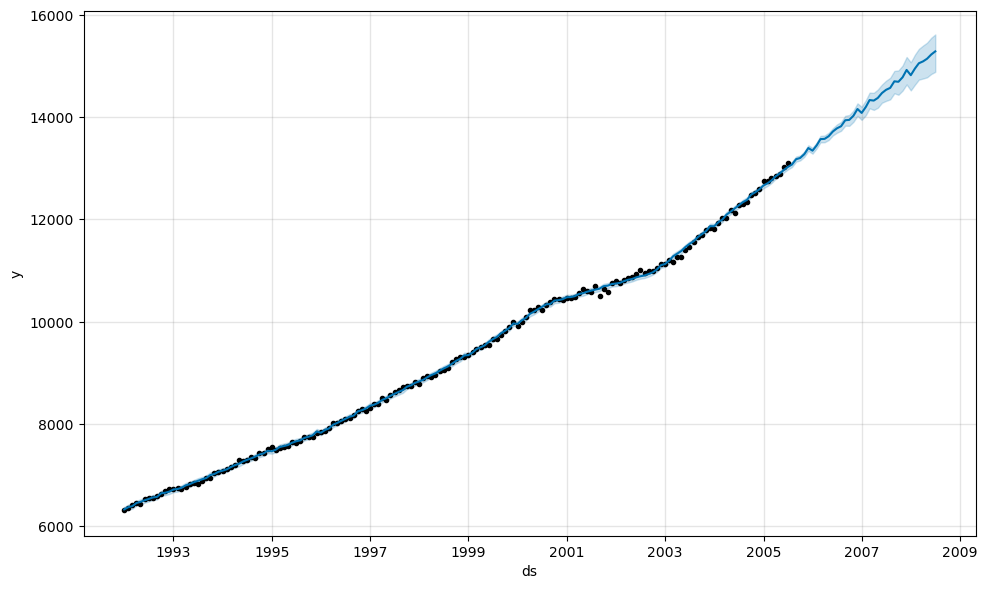

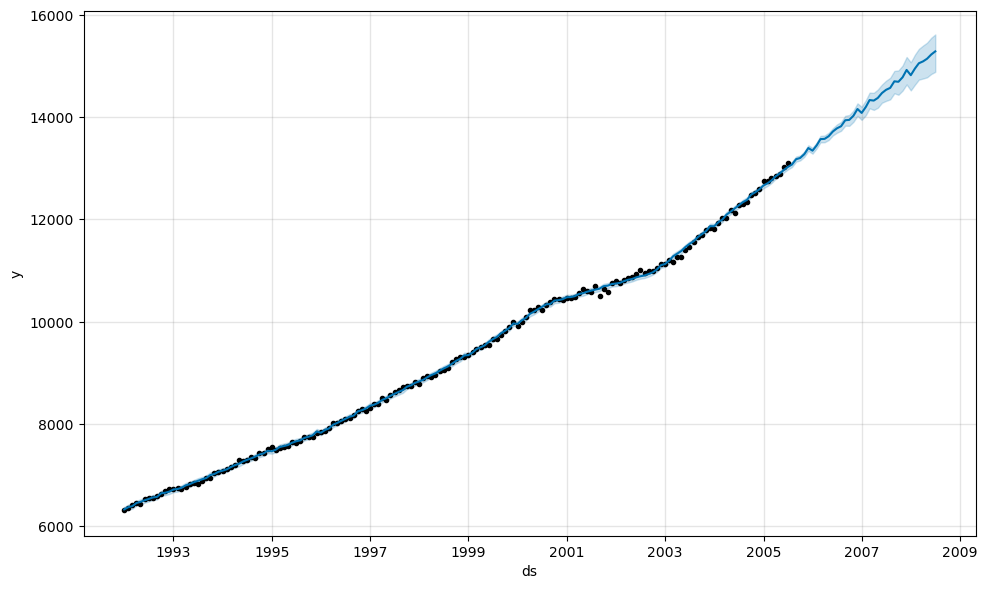

In [95]:
# Plot the Prophet predictions for the 9/11 trends data
model_katrina.plot(forecast_katrina)


c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

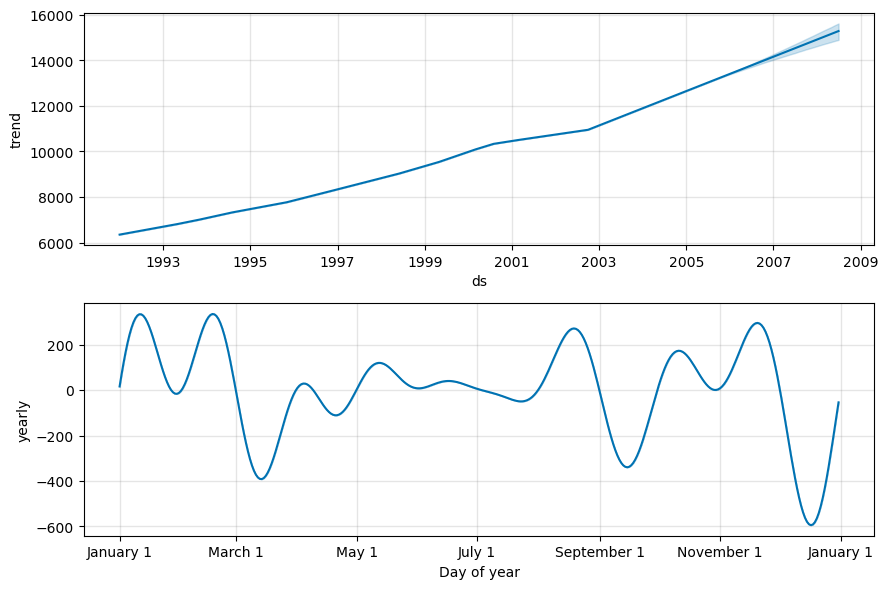

In [96]:
# Use the plot_components function to visualize the forecast results
figure = model_katrina.plot_components(forecast_katrina)

<Axes: xlabel='ds'>

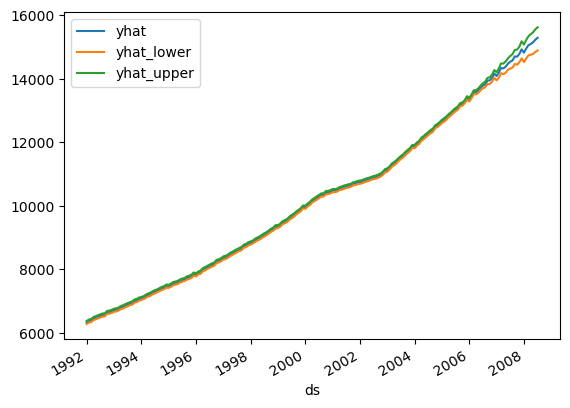

In [97]:
# set 'ds' as index
# From the `forecast_katrina` DataFrame, plot to visualize
# the yhat, yhat_lower, and yhat_upper columns
forecast_katrina = forecast_katrina.set_index('ds')
forecast_katrina[['yhat', 'yhat_lower', 'yhat_upper']].plot()

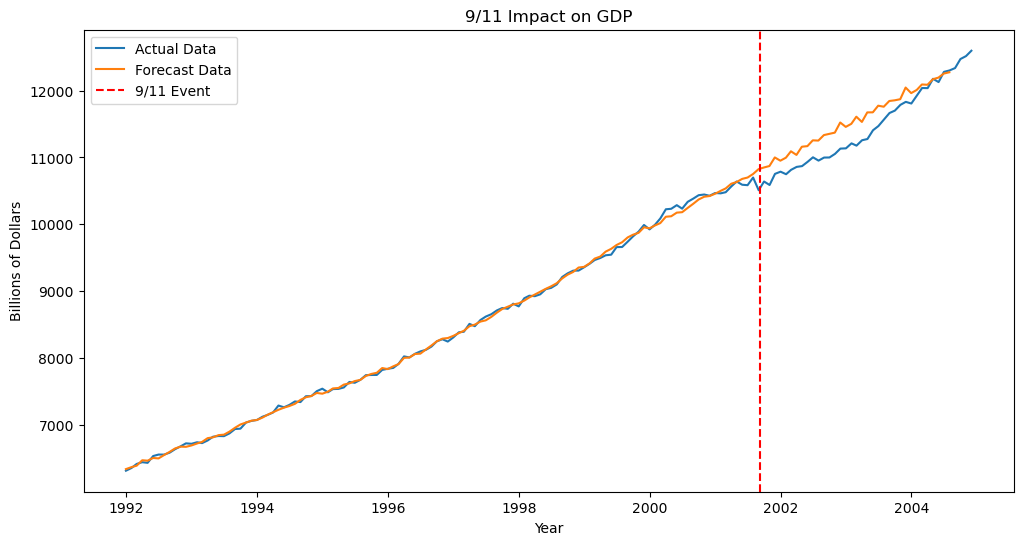

In [98]:
# Create a figure with a specified size
plt.figure(figsize=(12, 6))


# create nine_eleven_actual_gdp_df which is the gdp_df sliced from 1992 to 2004
# plot nine_eleven_actual_gdp_df and the forecast in the same plot

nine_eleven_actual_gdp_df= gdp_df.loc['1992':'2004']
plt.plot(nine_eleven_actual_gdp_df.index, nine_eleven_actual_gdp_df['Monthly Nominal GDP Index'], label = 'Actual Data')
plt.plot(forecast_9_11.index, forecast_9_11['yhat'], label= 'Forecast Data')
plt.title('9/11 Impact on GDP')
plt.xlabel('Year')
plt.ylabel('Billions of Dollars')
# make the vertical event line for 2001-09-11

event_date = pd.to_datetime('2001-09-11')
plt.axvline(x=event_date, color='red', linestyle='--', label='9/11 Event')
plt.legend()
plt.show()


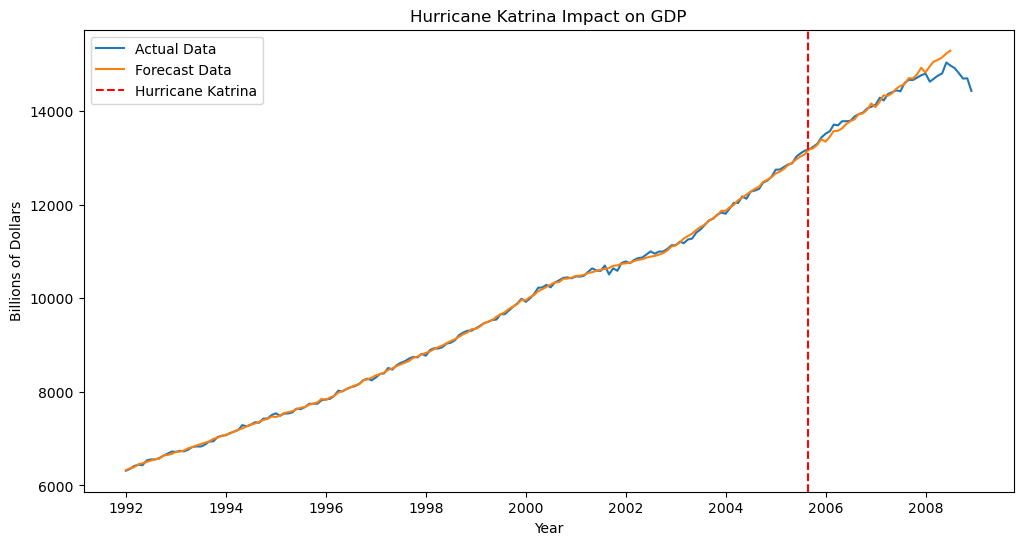

In [99]:
# Create a figure with a specified size
plt.figure(figsize=(12, 6))

# create katrina_actual_gdp_df which is the gdp_df sliced from 1992 to 2008
# plot katrina_actual_gdp_df and the forecast in the same plot
# create a legend
katrina_actual_gdp_df= gdp_df.loc['1992':'2008']
plt.plot(katrina_actual_gdp_df.index, katrina_actual_gdp_df['Monthly Nominal GDP Index'], label = 'Actual Data')
plt.plot(forecast_katrina.index, forecast_katrina['yhat'], label= 'Forecast Data')
plt.title('Hurricane Katrina Impact on GDP')
plt.xlabel('Year')
plt.ylabel('Billions of Dollars')

# make the vertical event line for 2001-09-11
event_date = pd.to_datetime('2005-08-23')
plt.axvline(x=event_date, color='red', linestyle='--', label='Hurricane Katrina')

plt.legend()
plt.show()

In [100]:
# export gdp_df as csv
# export forecast_9_11 as csv
# export forecast_katrina as csv
gdp_df.to_csv('resources/gdp_cleaned.csv')
forecast_9_11.to_csv('resources/forecast_9_11_gdp.csv')
forecast_katrina.to_csv('resources/forecast_katrina_gdp.csv')